In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from math import pi
import warnings
warnings.filterwarnings('ignore')
print("Library OK!")

file_id = "1XtaKeD7b-la2R1ygFBNLj16VD1k0MB2Q"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.csv", quiet=False)
df = pd.read_csv("data.csv")

print(f"\n✓ Data loaded!")
print(f"✓ Shape: {df.shape[0]} customers, {df.shape[1]} features")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Library OK!


Downloading...
From: https://drive.google.com/uc?id=1XtaKeD7b-la2R1ygFBNLj16VD1k0MB2Q
To: /content/data.csv
100%|██████████| 1.01M/1.01M [00:00<00:00, 23.9MB/s]



✓ Data loaded!
✓ Shape: 8950 customers, 18 features

Columns: ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

# STEP 1: Data Exploration and Missing Value Handling

Step ini adalah untuk memuat data, memahami kualitasnya, serta menangani nilai yang hilang (missing values). Proses dimulai dengan pemuatan data dan pengecekan awal, yaitu mengimpor library yang diperlukan seperti pandas, numpy, dan scikit-learn, kemudian menggunakan gdown untuk mengunduh dataset dari Google Drive. Setelah itu, bentuk data (shape) dan beberapa baris pertama ditampilkan melalui df.head() untuk memperoleh gambaran awal struktur dataset. Selanjutnya, dilakukan visualisasi dan imputasi missing value. Library missingno digunakan untuk memvisualisasikan pola missing value melalui matrix dan bar chart, sehingga memudahkan identifikasi fitur yang memiliki nilai hilang. Untuk penanganan missing value, digunakan teknik KNNImputer, yang mencari lima tetangga terdekat dari setiap baris yang memiliki nilai hilang, lalu mengisi nilai tersebut menggunakan rata-rata tertimbang dari tetangga-tetangga tersebut—metode yang lebih canggih dibanding pengisian dengan rata-rata atau median. Setelah proses imputasi, ditampilkan ringkasan statistik seperti mean, standar deviasi, skewness, dan kurtosis untuk menilai distribusi setiap fitur pasca imputasi.


🔍 DATA QUALITY ASSESSMENT


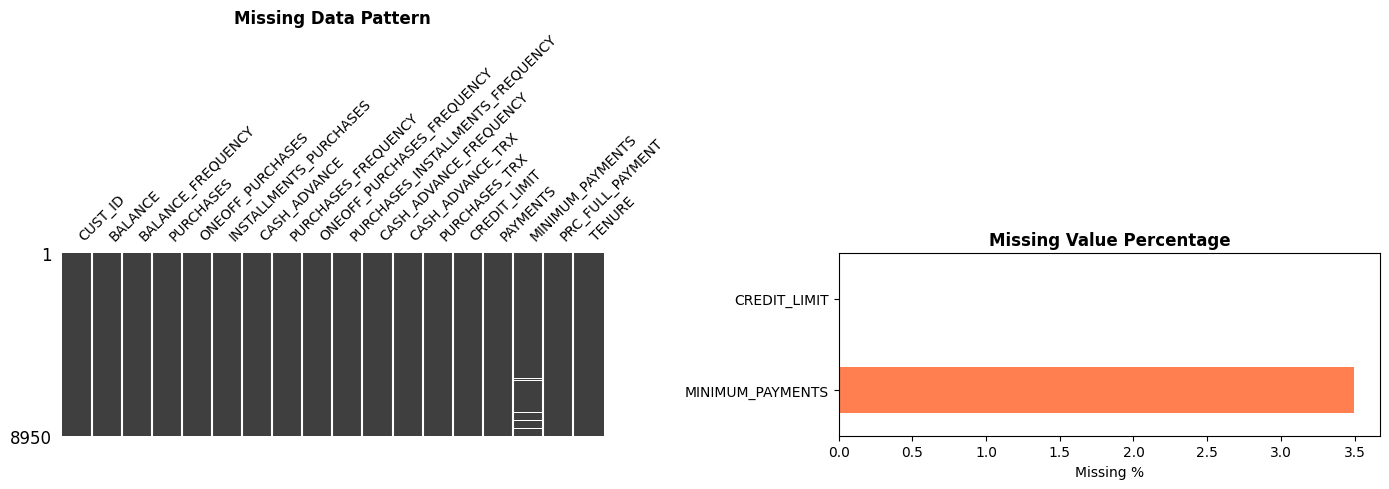


✅ Advanced KNN Imputation completed
✅ All missing values handled: 0 nulls remaining

📊 STATISTICAL SUMMARY:
                                     mean      std  skewness  kurtosis
BALANCE                           1564.47  2081.53      2.39      7.67
BALANCE_FREQUENCY                    0.88     0.24     -2.02      3.09
PURCHASES                         1003.20  2136.63      8.14    111.39
ONEOFF_PURCHASES                   592.44  1659.89     10.05    164.19
INSTALLMENTS_PURCHASES             411.07   904.34      7.30     96.58
CASH_ADVANCE                       978.87  2097.16      5.17     52.90
PURCHASES_FREQUENCY                  0.49     0.40      0.06     -1.64
ONEOFF_PURCHASES_FREQUENCY           0.20     0.30      1.54      1.16
PURCHASES_INSTALLMENTS_FREQUENCY     0.36     0.40      0.51     -1.40
CASH_ADVANCE_FREQUENCY               0.14     0.20      1.83      3.33
CASH_ADVANCE_TRX                     3.25     6.82      5.72     61.65
PURCHASES_TRX                       14.

In [2]:
# Alternative approach: Visual-first exploration with advanced imputation
import missingno as msno

print("\n🔍 DATA QUALITY ASSESSMENT")
print("="*60)

# Missing value visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrix visualization
msno.matrix(df, ax=axes[0], fontsize=10)
axes[0].set_title('Missing Data Pattern', fontweight='bold')

# Bar chart
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct[missing_pct > 0].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_xlabel('Missing %')
axes[1].set_title('Missing Value Percentage', fontweight='bold')
plt.tight_layout()
plt.show()

# Advanced imputation using KNN
from sklearn.impute import KNNImputer

df_clean = df.copy()
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'CUST_ID' in numeric_cols:
    numeric_cols.remove('CUST_ID')

# KNN Imputation (more sophisticated than median)
imputer = KNNImputer(n_neighbors=5, weights='distance')
df_clean[numeric_cols] = imputer.fit_transform(df_clean[numeric_cols])

print(f"\n✅ Advanced KNN Imputation completed")
print(f"✅ All missing values handled: {df_clean.isnull().sum().sum()} nulls remaining")

# Statistical summary with skewness
print("\n📊 STATISTICAL SUMMARY:")
stats = df_clean[numeric_cols].describe().T
stats['skewness'] = df_clean[numeric_cols].skew()
stats['kurtosis'] = df_clean[numeric_cols].kurtosis()
print(stats[['mean', 'std', 'skewness', 'kurtosis']].round(2))

# STEP 2: Outlier Handling and Feature Engineering

Step ini berfokus pada penanganan nilai ekstrem (outliers) serta penciptaan fitur-fitur baru yang dapat memberikan wawasan bisnis yang lebih mendalam. Untuk mendeteksi outlier, digunakan model Isolation Forest dengan pengaturan kontaminasi sebesar 10%. Alih-alih menghapus atau melakukan clipping, outlier ditangani menggunakan teknik Winsorization, yaitu mengganti nilai yang berada di atas persentil ke-95 dan di bawah persentil ke-5 dengan nilai pada persentil tersebut. Pendekatan ini efektif dalam mengurangi pengaruh nilai ekstrem tanpa kehilangan data berharga. Selanjutnya, proses feature engineering dilakukan dengan membuat tujuh fitur lanjutan yang bersifat rasio atau komposit untuk menggambarkan perilaku bisnis pelanggan secara lebih kaya. Fitur-fitur tersebut meliputi SPENDING_POWER (rasio pembelian terhadap batas kredit), LIQUIDITY_STRESS (rasio cash advance terhadap saldo), PAYMENT_EFFICIENCY (rasio pembayaran terhadap minimum pembayaran), TRX_SIZE (rata-rata ukuran transaksi), CASH_DEPENDENCY (proporsi cash advance dari total transaksi), FINANCIAL_HEALTH (skor komposit berdasarkan pemanfaatan kredit, persentase pembayaran penuh, dan ketergantungan non-tunai), serta ENGAGEMENT_SCORE (skor komposit berdasarkan frekuensi pembelian, frekuensi saldo, dan lama keanggotaan).

In [3]:
# Alternative: Isolation Forest for outlier detection + Advanced features
from sklearn.ensemble import IsolationForest

df_out = df_clean.copy()
num_cols = [c for c in df_out.columns if c != 'CUST_ID' and df_out[c].dtype in [np.float64, np.int64]]

# Detect outliers using Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = iso_forest.fit_predict(df_out[num_cols])
n_outliers = (outlier_labels == -1).sum()

print(f"\n🔍 Isolation Forest Outlier Detection:")
print(f"   Found {n_outliers} outliers ({n_outliers/len(df_out)*100:.2f}%)")

# Winsorization instead of clipping
from scipy.stats.mstats import winsorize
for col in num_cols:
    df_out[col] = winsorize(df_out[col], limits=[0.05, 0.05])

print(f"✅ Applied Winsorization (5% from each tail)")

# Advanced Feature Engineering
eps = 1e-8
df_feat = df_out.copy()

# Behavioral ratios
df_feat['SPENDING_POWER'] = df_feat['PURCHASES'] / (df_feat['CREDIT_LIMIT'] + eps)
df_feat['LIQUIDITY_STRESS'] = df_feat['CASH_ADVANCE'] / (df_feat['BALANCE'] + eps)
df_feat['PAYMENT_EFFICIENCY'] = df_feat['PAYMENTS'] / (df_feat['MINIMUM_PAYMENTS'] + eps)

# Transaction patterns
df_feat['TRX_SIZE'] = df_feat['PURCHASES'] / (df_feat['PURCHASES_TRX'] + eps)
df_feat['CASH_DEPENDENCY'] = (df_feat['CASH_ADVANCE_TRX'] /
                               (df_feat['PURCHASES_TRX'] + df_feat['CASH_ADVANCE_TRX'] + eps))

# Financial health score (composite)
df_feat['FINANCIAL_HEALTH'] = (
    (1 - df_feat['BALANCE'] / (df_feat['CREDIT_LIMIT'] + eps)).clip(0, 1) * 0.3 +
    df_feat['PRC_FULL_PAYMENT'] * 0.4 +
    (1 - df_feat['CASH_DEPENDENCY']).clip(0, 1) * 0.3
)

# Engagement metrics
df_feat['ENGAGEMENT_SCORE'] = (
    (df_feat['PURCHASES_FREQUENCY'] * 0.4) +
    (df_feat['BALANCE_FREQUENCY'] * 0.3) +
    (df_feat['TENURE'] / df_feat['TENURE'].max() * 0.3)
)

# Replace infinities
df_feat.replace([np.inf, -np.inf], 0, inplace=True)

print(f"\n✅ Created 7 advanced behavioral features:")
print("   SPENDING_POWER, LIQUIDITY_STRESS, PAYMENT_EFFICIENCY,")
print("   TRX_SIZE, CASH_DEPENDENCY, FINANCIAL_HEALTH, ENGAGEMENT_SCORE")


🔍 Isolation Forest Outlier Detection:
   Found 895 outliers (10.00%)
✅ Applied Winsorization (5% from each tail)

✅ Created 7 advanced behavioral features:
   SPENDING_POWER, LIQUIDITY_STRESS, PAYMENT_EFFICIENCY,
   TRX_SIZE, CASH_DEPENDENCY, FINANCIAL_HEALTH, ENGAGEMENT_SCORE


# STEP 3: Feature Scaling and Dimensionality Reduction

Step ini bertujuan untuk melakukan standarisasi data serta reduksi dimensi agar algoritma clustering dapat bekerja secara optimal. Proses dimulai dengan feature scaling menggunakan StandardScaler, yang menstandarisasi setiap fitur sehingga memiliki rata-rata (μ) nol dan deviasi standar (σ) satu. Standarisasi ini penting agar semua fitur memberikan kontribusi yang seimbang dalam perhitungan jarak (distance) pada algoritma clustering. Setelah itu dilakukan reduksi dimensi menggunakan Principal Component Analysis (PCA) untuk menyederhanakan jumlah fitur sambil tetap mempertahankan sebagian besar variansi data. PCA diatur untuk mempertahankan 90% variansi, dan jumlah komponen yang lolos seleksi (misalnya N komponen) kemudian digunakan sebagai input utama untuk proses clustering. Hasilnya mencakup jumlah komponen PCA yang terpilih. Untuk memahami struktur data secara visual, dibuat scree plot PCA yang menunjukkan variansi kumulatif setiap komponen. Selain itu, digunakan t-SNE (t-distributed Stochastic Neighbor Embedding) untuk memvisualisasikan data dalam dua dimensi karena metode ini lebih unggul dibanding PCA dalam menangkap struktur lokal antar kelompok data.


✅ Standardized 24 features (mean=0, std=1)

✅ PCA Dimensionality Reduction:
   Original: 24 → Reduced: 11 components
   Variance retained: 91.08%


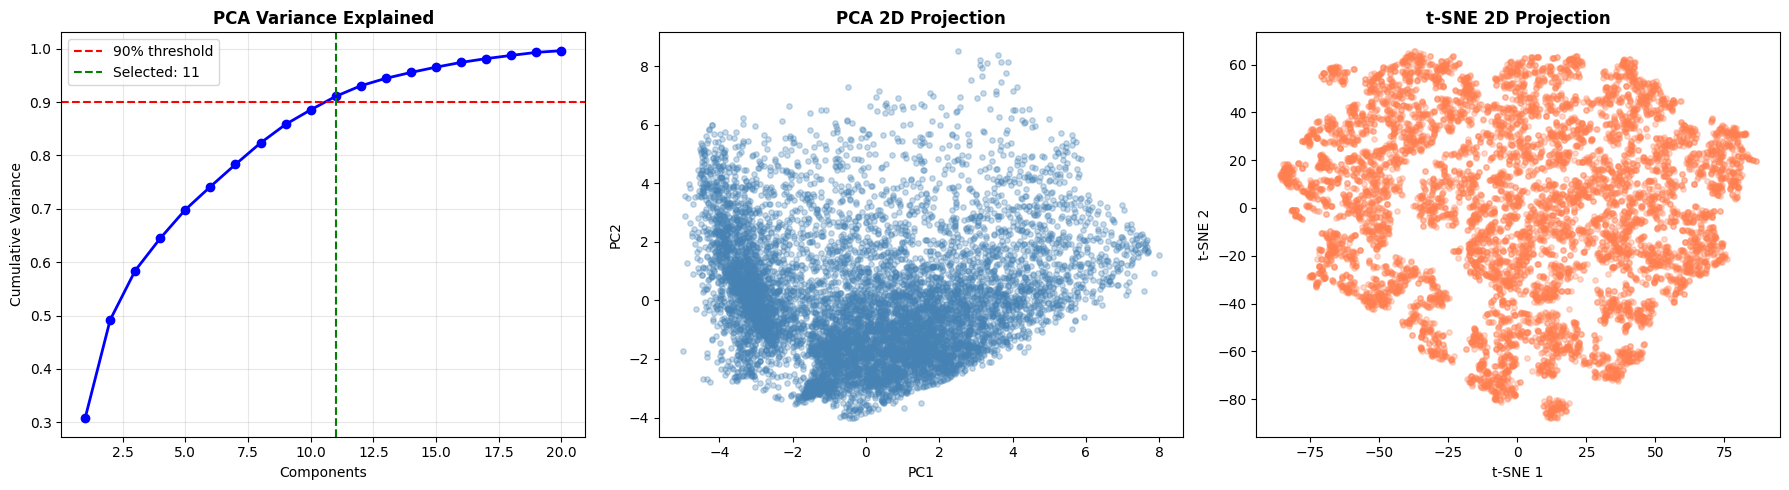

In [4]:
# Alternative: StandardScaler + t-SNE visualization
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

feature_cols = [c for c in df_feat.columns if c != 'CUST_ID']
X = df_feat[feature_cols].values

# StandardScaler (alternative to RobustScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"\n✅ Standardized {len(feature_cols)} features (mean=0, std=1)")

# PCA with elbow visualization
pca_full = PCA()
pca_full.fit(X_scaled)

# Find optimal components (90% variance)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.argmax(cumsum >= 0.90) + 1

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"\n✅ PCA Dimensionality Reduction:")
print(f"   Original: {X_scaled.shape[1]} → Reduced: {X_pca.shape[1]} components")
print(f"   Variance retained: {cumsum[n_components-1]:.2%}")

# t-SNE for 2D visualization (better than PCA for visualization)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scree plot
axes[0].plot(range(1, 21), cumsum[:20], 'bo-', lw=2)
axes[0].axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
axes[0].axvline(x=n_components, color='g', linestyle='--', label=f'Selected: {n_components}')
axes[0].set_xlabel('Components'); axes[0].set_ylabel('Cumulative Variance')
axes[0].set_title('PCA Variance Explained', fontweight='bold')
axes[0].legend(); axes[0].grid(alpha=0.3)

# PCA 2D
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.3, s=15, c='steelblue')
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
axes[1].set_title('PCA 2D Projection', fontweight='bold')

# t-SNE 2D
axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.3, s=15, c='coral')
axes[2].set_xlabel('t-SNE 1'); axes[2].set_ylabel('t-SNE 2')
axes[2].set_title('t-SNE 2D Projection', fontweight='bold')

plt.tight_layout()
plt.show()

# STEP 4: Determine Optimal Cluster

Step ini bertujuan menentukan jumlah cluster yang paling optimal dengan memanfaatkan berbagai metode evaluasi. Proses *clustering* dilakukan pada data yang telah direduksi dimensinya  untuk memastikan perhitungan jarak lebih stabil dan efisien. Berbagai metrik digunakan untuk mengevaluasi kualitas cluster, antara lain Silhouette Score, yang menilai seberapa mirip suatu objek dengan clusternya sendiri dibandingkan dengan cluster lain dan semakin tinggi nilainya semakin baik; Calinski–Harabasz Index, yang membandingkan dispersi antar-cluster dan intra-cluster di mana nilai yang lebih besar menunjukkan cluster yang padat dan terpisah; Davies–Bouldin Index, yang nilainya lebih rendah menandakan struktur cluster yang lebih terpisah; serta Bayesian Information Criterion (BIC) yang digunakan untuk membandingkan model dengan jumlah parameter berbeda, di mana nilai lebih rendah lebih baik. Selain itu, digunakan pula Gap Statistic, yang membandingkan inertia model dengan inertia model referensi dari data berdistribusi seragam, dan nilai gap tertinggi menunjukkan $K$ optimal. Untuk menentukan jumlah cluster terbaik, digunakan mekanisme *voting* dengan mengambil suara mayoritas dari empat metrik utama (Silhouette, Calinski–Harabasz, Davies–Bouldin, dan Gap Statistic). Hasil akhir kemudian divisualisasikan agar keputusan mengenai nilai OPTIMAL_K dapat didukung oleh bukti yang jelas dan terinterpretasi dengan baik.



🔍 EVALUATING CLUSTER NUMBERS...

📊 OPTIMAL K BY DIFFERENT METRICS:
   Silhouette: K=2
   Calinski-Harabasz: K=2
   Davies-Bouldin: K=10
   Gap Statistic: K=5

✅ CONSENSUS OPTIMAL K = 2 (majority vote)


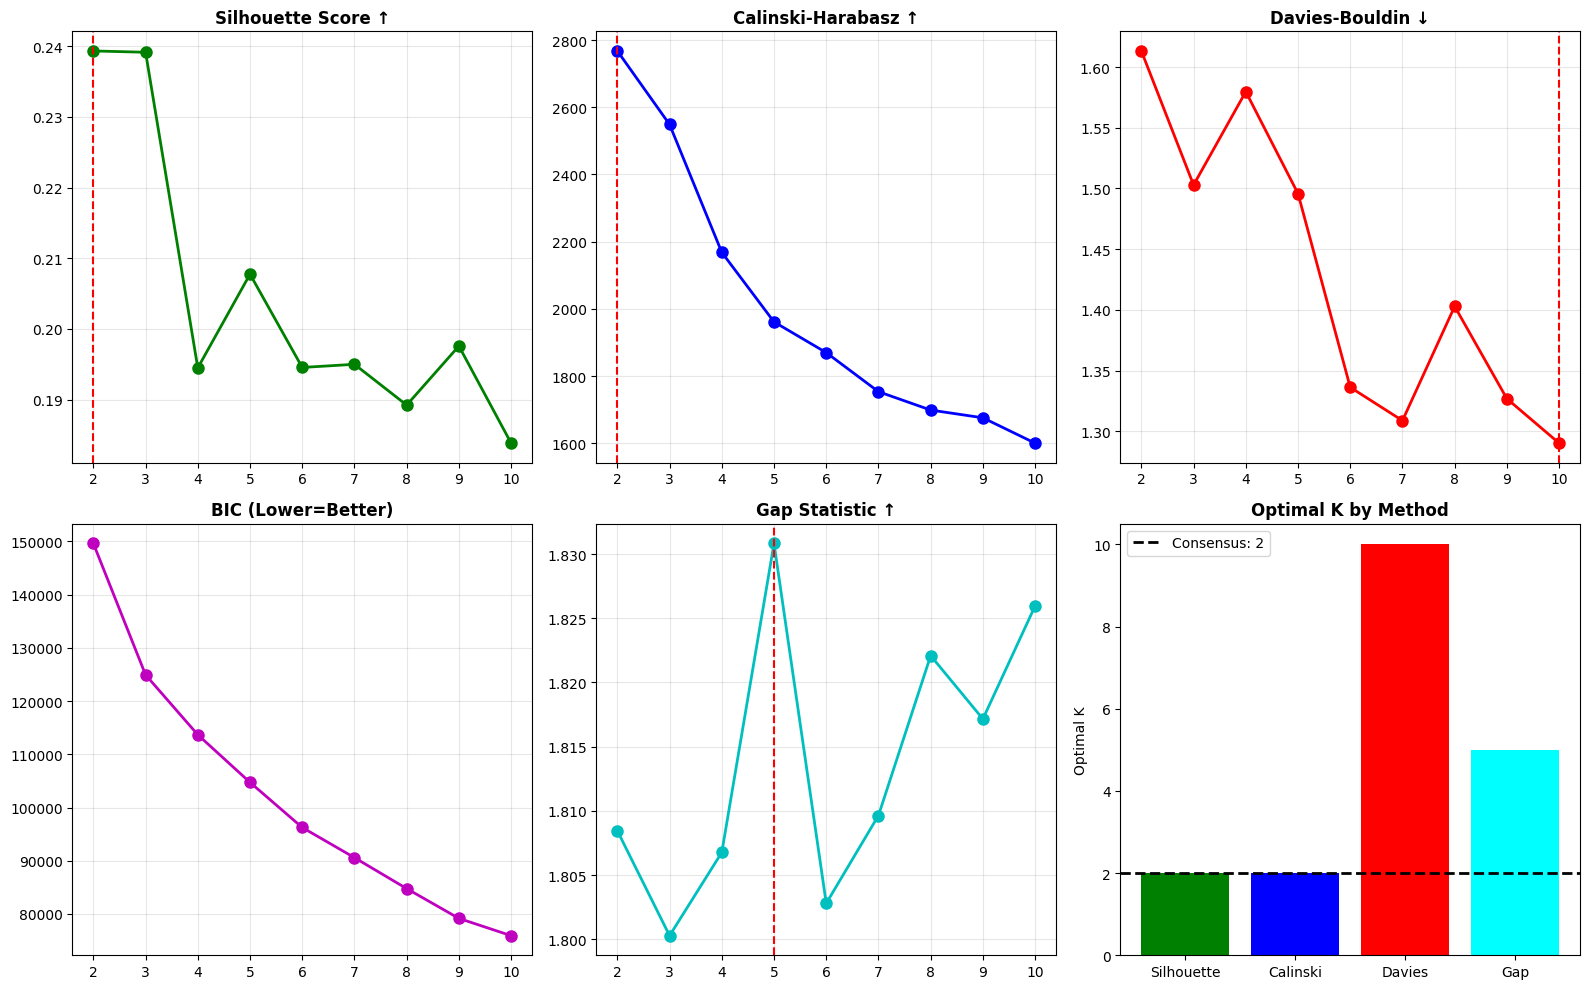

In [5]:
# Alternative: Gap Statistic + Multiple validation indices
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import cdist

def gap_statistic(X, k_range, n_refs=10):
    """Calculate Gap Statistic for optimal k"""
    gaps = []
    for k in k_range:
        # Actual clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        disp = sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1))

        # Reference distribution
        ref_disps = []
        for _ in range(n_refs):
            random_data = np.random.uniform(X.min(axis=0), X.max(axis=0), size=X.shape)
            km_ref = KMeans(n_clusters=k, random_state=42, n_init=10)
            km_ref.fit(random_data)
            ref_disp = sum(np.min(cdist(random_data, km_ref.cluster_centers_, 'euclidean'), axis=1))
            ref_disps.append(ref_disp)

        gap = np.log(np.mean(ref_disps)) - np.log(disp)
        gaps.append(gap)

    return gaps

K_range = range(2, 11)
metrics = {
    'k': [], 'silhouette': [], 'calinski': [], 'davies_bouldin': [],
    'bic': [], 'gap': []
}

print("\n🔍 EVALUATING CLUSTER NUMBERS...")
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)

    metrics['k'].append(k)
    metrics['silhouette'].append(silhouette_score(X_pca, labels))
    metrics['calinski'].append(calinski_harabasz_score(X_pca, labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(X_pca, labels))

    # BIC calculation
    m = k
    n = X_pca.shape[0]
    d = X_pca.shape[1]
    bic = km.inertia_ + np.log(n) * m * d
    metrics['bic'].append(bic)

# Gap Statistic
metrics['gap'] = gap_statistic(X_pca, K_range, n_refs=5)

# Multi-criteria decision
silhouette_best = K_range[np.argmax(metrics['silhouette'])]
calinski_best = K_range[np.argmax(metrics['calinski'])]
davies_best = K_range[np.argmin(metrics['davies_bouldin'])]
gap_best = K_range[np.argmax(metrics['gap'])]

print(f"\n📊 OPTIMAL K BY DIFFERENT METRICS:")
print(f"   Silhouette: K={silhouette_best}")
print(f"   Calinski-Harabasz: K={calinski_best}")
print(f"   Davies-Bouldin: K={davies_best}")
print(f"   Gap Statistic: K={gap_best}")

# Voting mechanism
from collections import Counter
votes = Counter([silhouette_best, calinski_best, davies_best, gap_best])
OPTIMAL_K = votes.most_common(1)[0][0]

print(f"\n✅ CONSENSUS OPTIMAL K = {OPTIMAL_K} (majority vote)")

# Enhanced visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

axes[0].plot(K_range, metrics['silhouette'], 'go-', lw=2, markersize=8)
axes[0].axvline(silhouette_best, color='r', linestyle='--')
axes[0].set_title('Silhouette Score ↑', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(K_range, metrics['calinski'], 'bo-', lw=2, markersize=8)
axes[1].axvline(calinski_best, color='r', linestyle='--')
axes[1].set_title('Calinski-Harabasz ↑', fontweight='bold')
axes[1].grid(alpha=0.3)

axes[2].plot(K_range, metrics['davies_bouldin'], 'ro-', lw=2, markersize=8)
axes[2].axvline(davies_best, color='r', linestyle='--')
axes[2].set_title('Davies-Bouldin ↓', fontweight='bold')
axes[2].grid(alpha=0.3)

axes[3].plot(K_range, metrics['bic'], 'mo-', lw=2, markersize=8)
axes[3].set_title('BIC (Lower=Better)', fontweight='bold')
axes[3].grid(alpha=0.3)

axes[4].plot(K_range, metrics['gap'], 'co-', lw=2, markersize=8)
axes[4].axvline(gap_best, color='r', linestyle='--')
axes[4].set_title('Gap Statistic ↑', fontweight='bold')
axes[4].grid(alpha=0.3)

# Summary
axes[5].bar(['Silhouette', 'Calinski', 'Davies', 'Gap'],
            [silhouette_best, calinski_best, davies_best, gap_best],
            color=['green', 'blue', 'red', 'cyan'])
axes[5].axhline(OPTIMAL_K, color='black', linestyle='--', lw=2, label=f'Consensus: {OPTIMAL_K}')
axes[5].set_ylabel('Optimal K')
axes[5].set_title('Optimal K by Method', fontweight='bold')
axes[5].legend()

plt.tight_layout()
plt.savefig('optimal_k_analysis.png', dpi=300)
plt.show()

# STEP 5: Apply Clustering Algorithms

Setelah nilai K optimal ditemukan, langkah selanjutnya adalah menerapkan dan membandingkan beberapa algoritma clustering untuk memilih model yang paling sesuai. Empat algoritma yang digunakan meliputi K-Means, yang bekerja dengan mencari pusat cluster (centroid) berdasarkan jarak; Gaussian Mixture Model (GMM), yang memodelkan cluster sebagai campuran distribusi Gaussian sehingga cocok untuk bentuk cluster elips; Spectral Clustering, yang berbasis graf dan efektif untuk mendeteksi cluster dengan bentuk non-konveks; serta Hierarchical Agglomerative Clustering dengan Ward linkage, yang membangun struktur hierarkis cluster secara bertahap. Masing-masing model dievaluasi menggunakan Silhouette Score pada data PCA, dan model dengan nilai Silhouette tertinggi dipilih sebagai BEST_METHOD, sementara label cluster yang dihasilkan (final_labels) digunakan untuk analisis lanjutan. Untuk memahami performa pemisahan cluster secara visual, dibuat scatter plot hasil clustering pada ruang t-SNE 2D sehingga perbedaan antar algoritma dapat diamati dengan lebih jelas.


🎯 APPLYING MULTIPLE CLUSTERING ALGORITHMS (K=2)...

🔷 K-MEANS:
   Silhouette: 0.2392
   Calinski-Harabasz: 2767.67

🔷 GAUSSIAN MIXTURE MODEL:
   Silhouette: 0.2383
   Calinski-Harabasz: 2075.26

🔷 SPECTRAL CLUSTERING:
   Silhouette: 0.8784
   Calinski-Harabasz: 112.91

🔷 HIERARCHICAL (Ward):
   Silhouette: 0.2045
   Calinski-Harabasz: 2180.33

✅ BEST METHOD: Spectral (Silhouette: 0.8784)


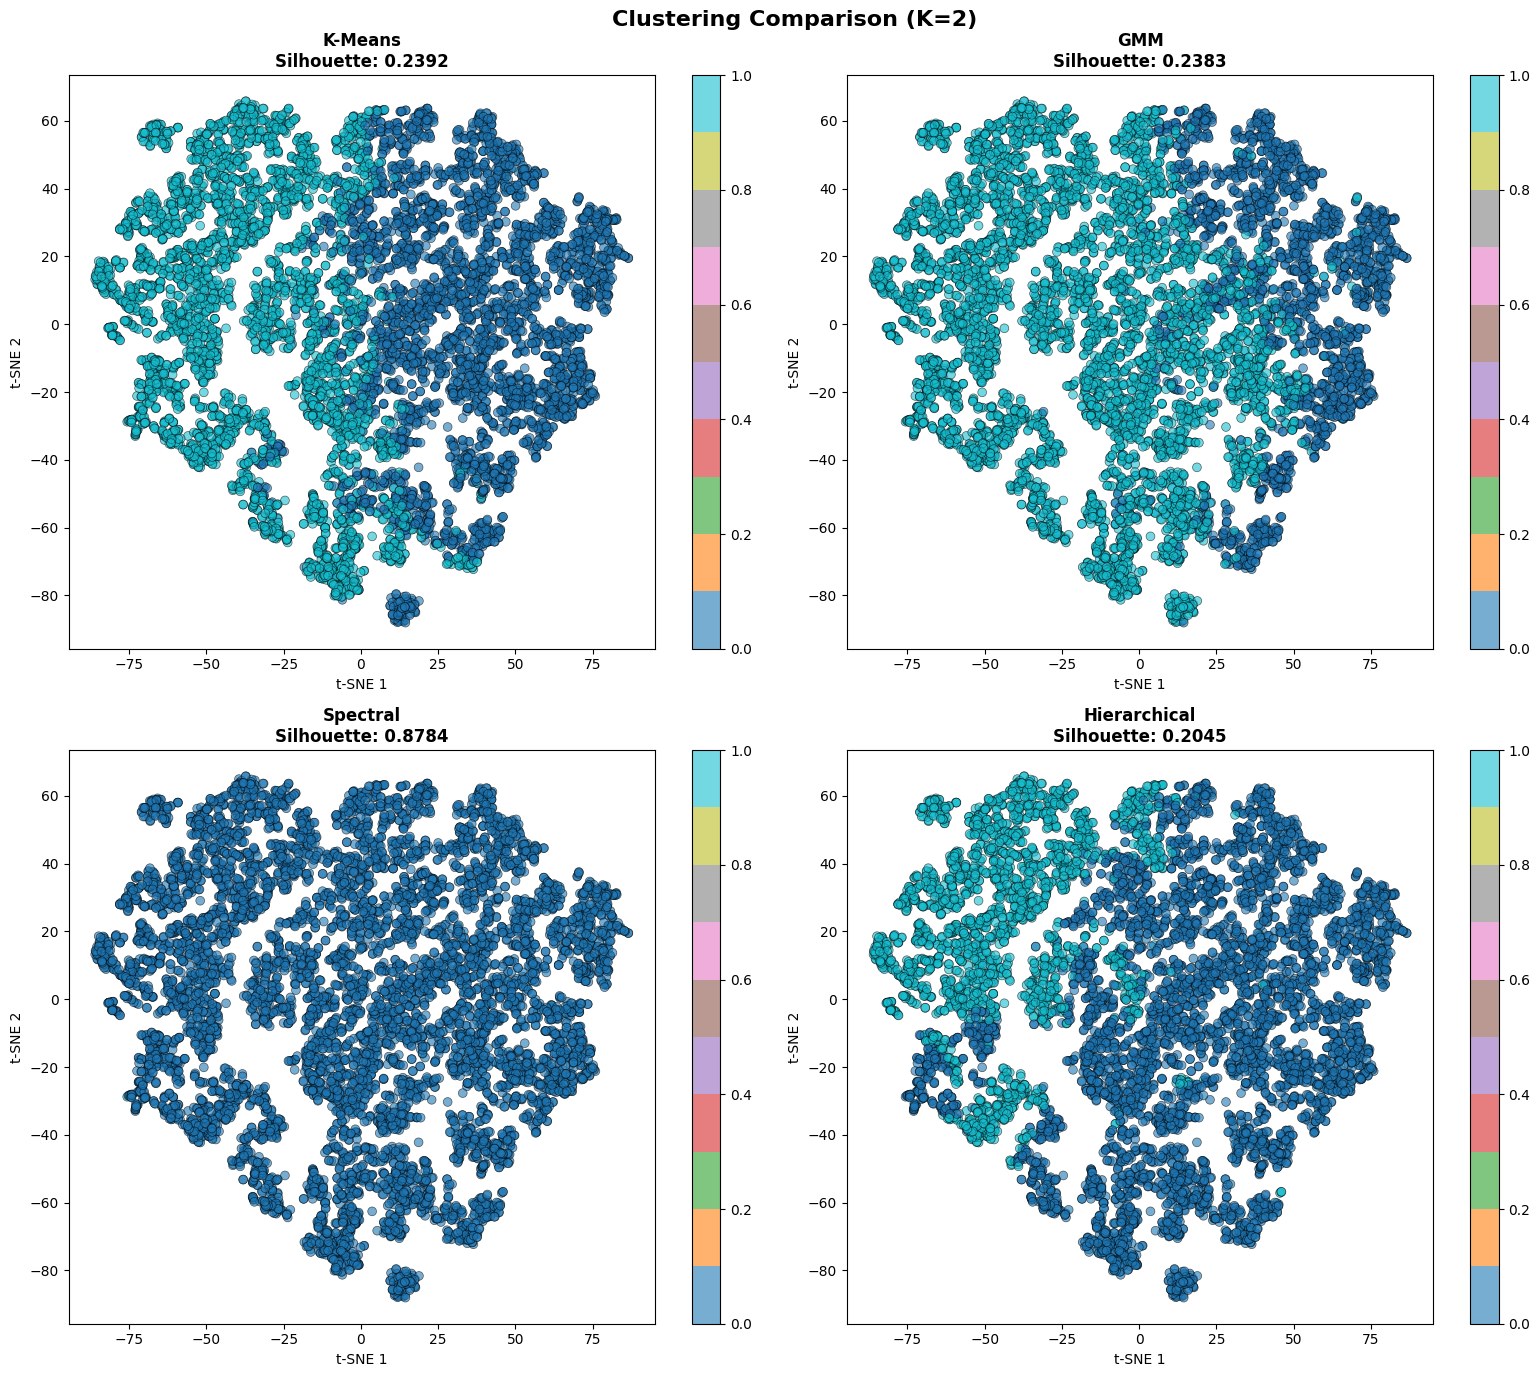

In [6]:
# Alternative: Add Gaussian Mixture Model + Spectral Clustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

print(f"\n🎯 APPLYING MULTIPLE CLUSTERING ALGORITHMS (K={OPTIMAL_K})...")

# 1. K-Means
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=20, max_iter=500)
km_labels = kmeans.fit_predict(X_pca)
km_silhouette = silhouette_score(X_pca, km_labels)
km_calinski = calinski_harabasz_score(X_pca, km_labels)

print(f"\n🔷 K-MEANS:")
print(f"   Silhouette: {km_silhouette:.4f}")
print(f"   Calinski-Harabasz: {km_calinski:.2f}")

# 2. Gaussian Mixture Model
gmm = GaussianMixture(n_components=OPTIMAL_K, random_state=42, covariance_type='full')
gmm_labels = gmm.fit_predict(X_pca)
gmm_silhouette = silhouette_score(X_pca, gmm_labels)
gmm_calinski = calinski_harabasz_score(X_pca, gmm_labels)

print(f"\n🔷 GAUSSIAN MIXTURE MODEL:")
print(f"   Silhouette: {gmm_silhouette:.4f}")
print(f"   Calinski-Harabasz: {gmm_calinski:.2f}")

# 3. Spectral Clustering
spectral = SpectralClustering(n_clusters=OPTIMAL_K, random_state=42, affinity='rbf')
spec_labels = spectral.fit_predict(X_pca)
spec_silhouette = silhouette_score(X_pca, spec_labels)
spec_calinski = calinski_harabasz_score(X_pca, spec_labels)

print(f"\n🔷 SPECTRAL CLUSTERING:")
print(f"   Silhouette: {spec_silhouette:.4f}")
print(f"   Calinski-Harabasz: {spec_calinski:.2f}")

# 4. Hierarchical (Ward)
hier = AgglomerativeClustering(n_clusters=OPTIMAL_K, linkage='ward')
hier_labels = hier.fit_predict(X_pca)
hier_silhouette = silhouette_score(X_pca, hier_labels)
hier_calinski = calinski_harabasz_score(X_pca, hier_labels)

print(f"\n🔷 HIERARCHICAL (Ward):")
print(f"   Silhouette: {hier_silhouette:.4f}")
print(f"   Calinski-Harabasz: {hier_calinski:.2f}")

# Select best algorithm
scores = {
    'K-Means': (km_labels, km_silhouette),
    'GMM': (gmm_labels, gmm_silhouette),
    'Spectral': (spec_labels, spec_silhouette),
    'Hierarchical': (hier_labels, hier_silhouette)
}

best_method = max(scores.items(), key=lambda x: x[1][1])
final_labels = best_method[1][0]

print(f"\n✅ BEST METHOD: {best_method[0]} (Silhouette: {best_method[1][1]:.4f})")

# Visualization on t-SNE space
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
methods = ['K-Means', 'GMM', 'Spectral', 'Hierarchical']
labels_list = [km_labels, gmm_labels, spec_labels, hier_labels]

for ax, method, labels in zip(axes.ravel(), methods, labels_list):
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels,
                        cmap='tab10', alpha=0.6, s=40, edgecolors='black', linewidth=0.5)
    ax.set_title(f'{method}\nSilhouette: {scores[method][1]:.4f}',
                 fontweight='bold', fontsize=12)
    ax.set_xlabel('t-SNE 1'); ax.set_ylabel('t-SNE 2')
    plt.colorbar(scatter, ax=ax)

plt.suptitle(f'Clustering Comparison (K={OPTIMAL_K})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('clustering_methods_comparison.png', dpi=300)
plt.show()

# STEP 6: Hierarchical Dendrogram

Langkah ini berfokus pada visualisasi serta pemahaman struktur hierarki dalam data, yang merupakan karakteristik utama dari Hierarchical Clustering. Untuk memudahkan interpretasi, dibuat dendrogram dengan mengambil sampel data hingga maksimum 2000 titik agar visualisasinya tetap jelas dan tidak terlalu padat. Dendrogram dibangun menggunakan fungsi linkage dari SciPy, kemudian dibandingkan empat metode linkage yang berbeda—Ward, Complete, Average, dan Single—untuk melihat bagaimana masing-masing metode menggabungkan data menjadi struktur hierarki. Sebuah garis merah ditambahkan pada dendrogram untuk menandai batas potong (cut-off) yang menghasilkan jumlah cluster sesuai nilai OPTIMAL_K. Melalui visualisasi ini, dendrogram memberikan wawasan mengenai bagaimana cluster terbentuk dan bergabung pada berbagai level, sehingga membantu memahami struktur internal data dan mendukung pemilihan jumlah cluster yang optimal secara visual.

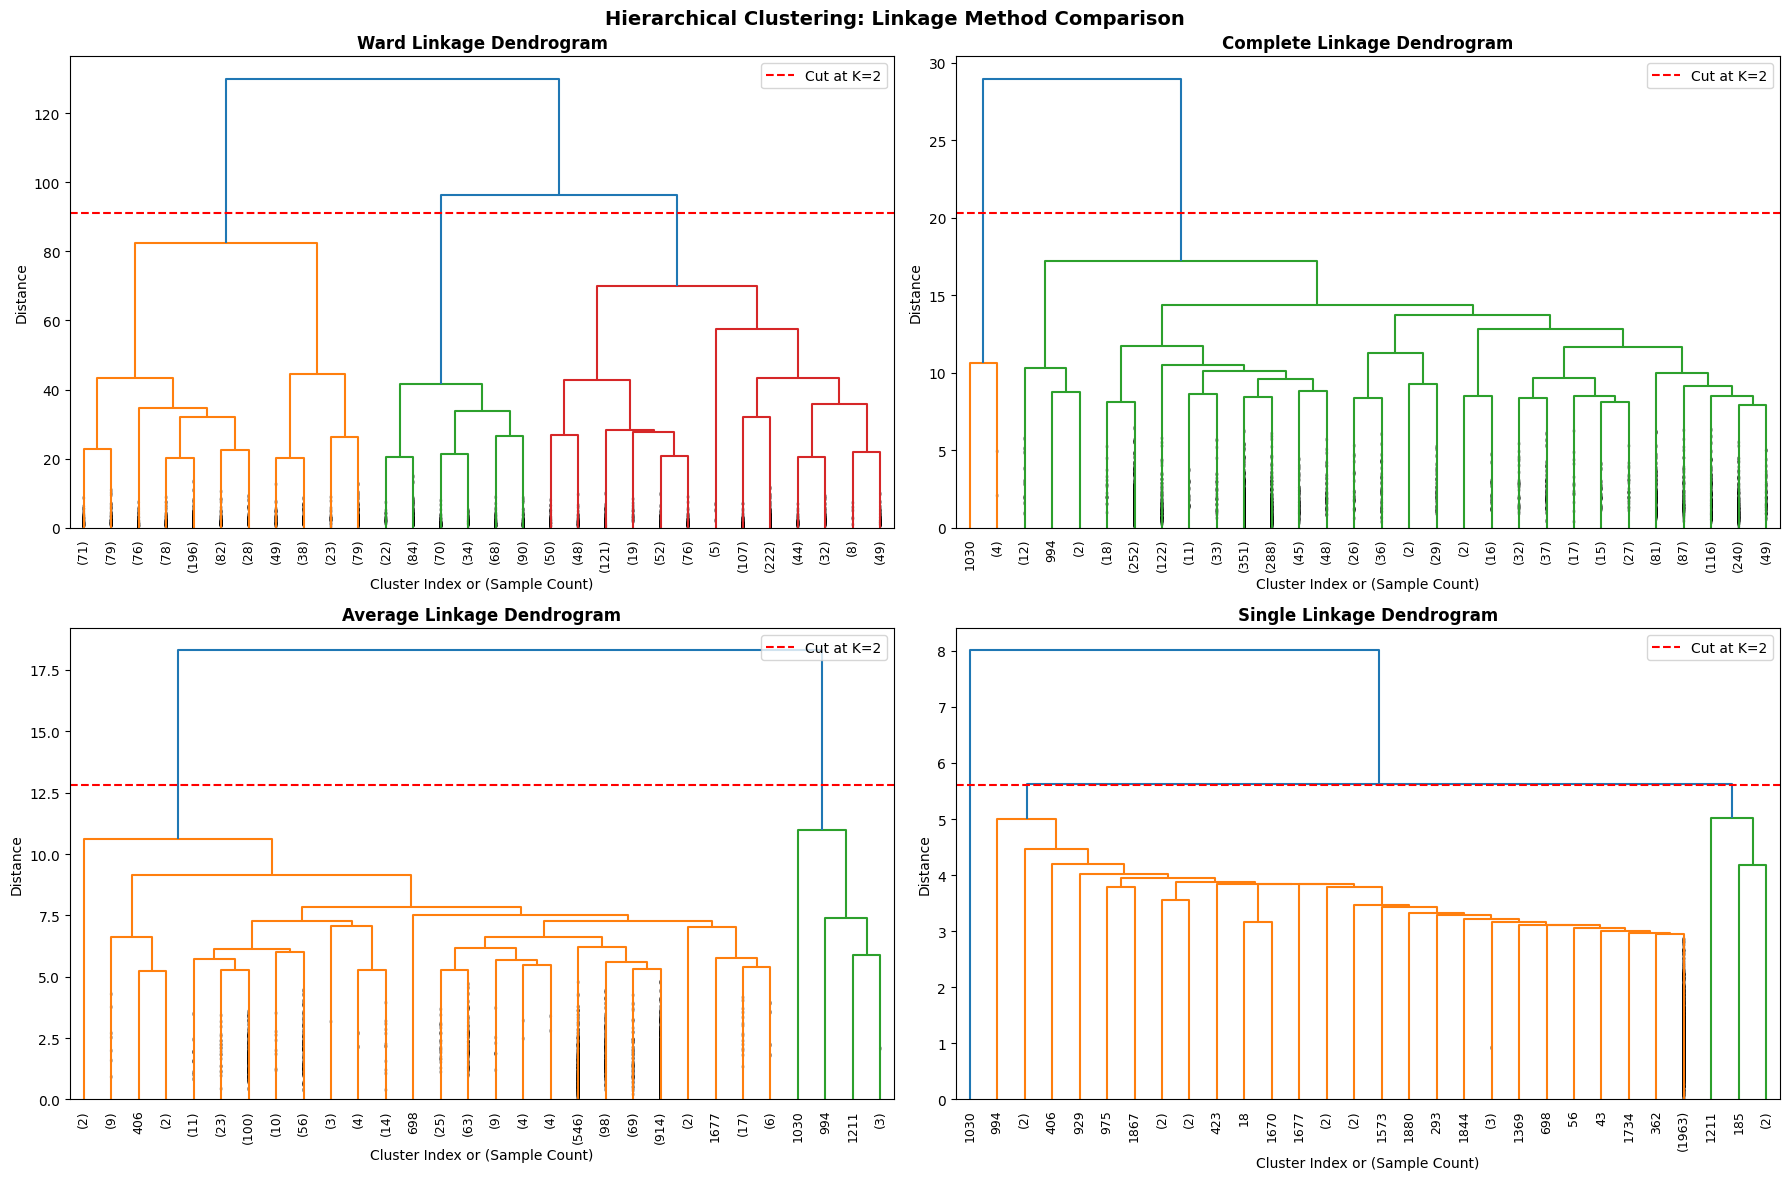

✅ Dendrogram shows hierarchical structure with different linkage methods
   Red line indicates optimal cut for K=2 clusters


In [7]:
# Alternative: Interactive dendrogram with color threshold
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Sample for visualization
sample_size = min(2000, len(X_pca))
sample_idx = np.random.choice(len(X_pca), sample_size, replace=False)
X_sample = X_pca[sample_idx]

# Different linkage methods comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
linkage_methods = ['ward', 'complete', 'average', 'single']

for ax, method in zip(axes.ravel(), linkage_methods):
    Z = linkage(X_sample, method=method)

    dendrogram(Z, ax=ax, truncate_mode='lastp', p=30,
               leaf_rotation=90, leaf_font_size=9,
               show_contracted=True, color_threshold=0.7*max(Z[:,2]))

    ax.set_title(f'{method.capitalize()} Linkage Dendrogram',
                 fontweight='bold', fontsize=12)
    ax.set_xlabel('Cluster Index or (Sample Count)', fontsize=10)
    ax.set_ylabel('Distance', fontsize=10)
    ax.axhline(y=0.7*max(Z[:,2]), color='red', linestyle='--',
               label=f'Cut at K={OPTIMAL_K}')
    ax.legend()

plt.suptitle('Hierarchical Clustering: Linkage Method Comparison',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('dendrogram_comparison.png', dpi=300)
plt.show()

print("✅ Dendrogram shows hierarchical structure with different linkage methods")
print(f"   Red line indicates optimal cut for K={OPTIMAL_K} clusters")

# STEP 7: Cluster Profiling

Langkah ini bertujuan menghitung karakteristik statistik dari setiap cluster yang telah terbentuk, sehingga dapat digunakan sebagai dasar untuk interpretasi bisnis. Proses dimulai dengan penyatuan data, yaitu menambahkan kolom Cluster—yang berisi final_labels dari model clustering terbaik—ke dalam dataframe fitur yang telah direkayasa (df_feat). Setelah itu dilakukan analisis statistik dengan menampilkan distribusi ukuran cluster dalam bentuk jumlah pelanggan dan persentasenya. Data kemudian dikelompokkan berdasarkan nilai cluster untuk menghitung berbagai metrik penting seperti rata-rata (mean), median, dan standar deviasi (std) pada fitur-fitur utama seperti BALANCE, PURCHASES, dan FINANCIAL_HEALTH. Analisis juga mencakup perhitungan persentil (25th dan 75th) guna memahami rentang nilai pada setiap cluster serta mengidentifikasi karakteristik unik yang menonjol. Sebagai bagian akhir, seluruh hasil profil cluster disimpan ke file cluster_detailed_profiles.csv, sedangkan data pelanggan beserta label clusternya disimpan dalam customers_with_clusters.csv untuk kebutuhan analisis lanjutan atau pemodelan berikutnya.

In [8]:
# Alternative: Advanced profiling with percentiles and distributions
df_clustered = df_feat.copy()
df_clustered['Cluster'] = final_labels

print("\n" + "="*70)
print("📊 COMPREHENSIVE CLUSTER ANALYSIS")
print("="*70)

# Cluster size distribution
cluster_dist = df_clustered['Cluster'].value_counts().sort_index()
print("\n🎯 Cluster Distribution:")
for c in cluster_dist.index:
    n = cluster_dist[c]
    pct = n / len(df_clustered) * 100
    bar = '█' * int(pct / 2)
    print(f"   Cluster {c}: {n:>5,} customers ({pct:>5.1f}%) {bar}")

# Select profiling features
profile_features = [
    'BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS',
    'PURCHASES_TRX', 'CASH_ADVANCE_TRX', 'PRC_FULL_PAYMENT',
    'SPENDING_POWER', 'FINANCIAL_HEALTH', 'ENGAGEMENT_SCORE', 'CASH_DEPENDENCY'
]
profile_features = [f for f in profile_features if f in df_clustered.columns]

# Advanced statistics: mean, median, std
profile_stats = df_clustered.groupby('Cluster')[profile_features].agg(['mean', 'median', 'std'])

print("\n📈 Cluster Profiles (Mean, Median, Std):")
print(profile_stats.round(2).to_string())

# Percentile analysis
percentile_25 = df_clustered.groupby('Cluster')[profile_features].quantile(0.25)
percentile_75 = df_clustered.groupby('Cluster')[profile_features].quantile(0.75)

print("\n📊 Cluster Percentiles (25th & 75th):")
print("25th Percentile:")
print(percentile_25.round(2).to_string())
print("\n75th Percentile:")
print(percentile_75.round(2).to_string())

# Save comprehensive profiles
profile_stats.to_csv('cluster_detailed_profiles.csv')
df_clustered.to_csv('customers_with_clusters.csv', index=False)

print("\n✅ Saved: cluster_detailed_profiles.csv, customers_with_clusters.csv")


📊 COMPREHENSIVE CLUSTER ANALYSIS

🎯 Cluster Distribution:
   Cluster 0: 8,949 customers (100.0%) █████████████████████████████████████████████████
   Cluster 1:     1 customers (  0.0%) 

📈 Cluster Profiles (Mean, Median, Std):
         BALANCE                  PURCHASES                  CASH_ADVANCE                  CREDIT_LIMIT                  PAYMENTS                   PURCHASES_TRX              CASH_ADVANCE_TRX              PRC_FULL_PAYMENT              SPENDING_POWER              FINANCIAL_HEALTH              ENGAGEMENT_SCORE              CASH_DEPENDENCY             
            mean  median      std      mean  median      std         mean  median      std         mean  median      std     mean   median      std          mean median   std             mean median   std             mean median   std           mean median   std             mean median   std             mean median   std            mean median   std
Cluster                                                            

# STEP 8: Cluster Visualization

Step ini berfokus pada pembuatan visualisasi yang memudahkan manajer bisnis maupun analis dalam memahami perbedaan antar cluster secara cepat dan intuitif. Visualisasi pertama adalah box plot untuk berbagai fitur kunci, yang dikelompokkan berdasarkan cluster. Plot ini efektif menampilkan median, rentang interkuartil (IQR), serta distribusi nilai sehingga karakteristik setiap cluster dapat dibandingkan dengan jelas. Selanjutnya digunakan parallel coordinates plot, yang dibuat dengan mengambil sampel data dan menormalisasi fitur-fitur kunci. Setiap garis pada plot mewakili satu pelanggan, dan pola lintasan garis menunjukkan perbedaan multivariat antar cluster—misalnya ketika satu cluster consistently tinggi pada fitur X namun rendah pada fitur Y. Visualisasi terakhir adalah enhanced heatmap berbasis Z-Score. Rata-rata setiap fitur dihitung per cluster, kemudian dinormalisasi menggunakan Z-Score terhadap keseluruhan populasi. Hasilnya divisualisasikan dalam bentuk heatmap, di mana warna merah menunjukkan fitur dengan nilai sangat tinggi dan biru menunjukkan nilai sangat rendah relatif terhadap rata-rata umum. Dengan demikian, ciri khas setiap cluster dapat dikenali secara instan.

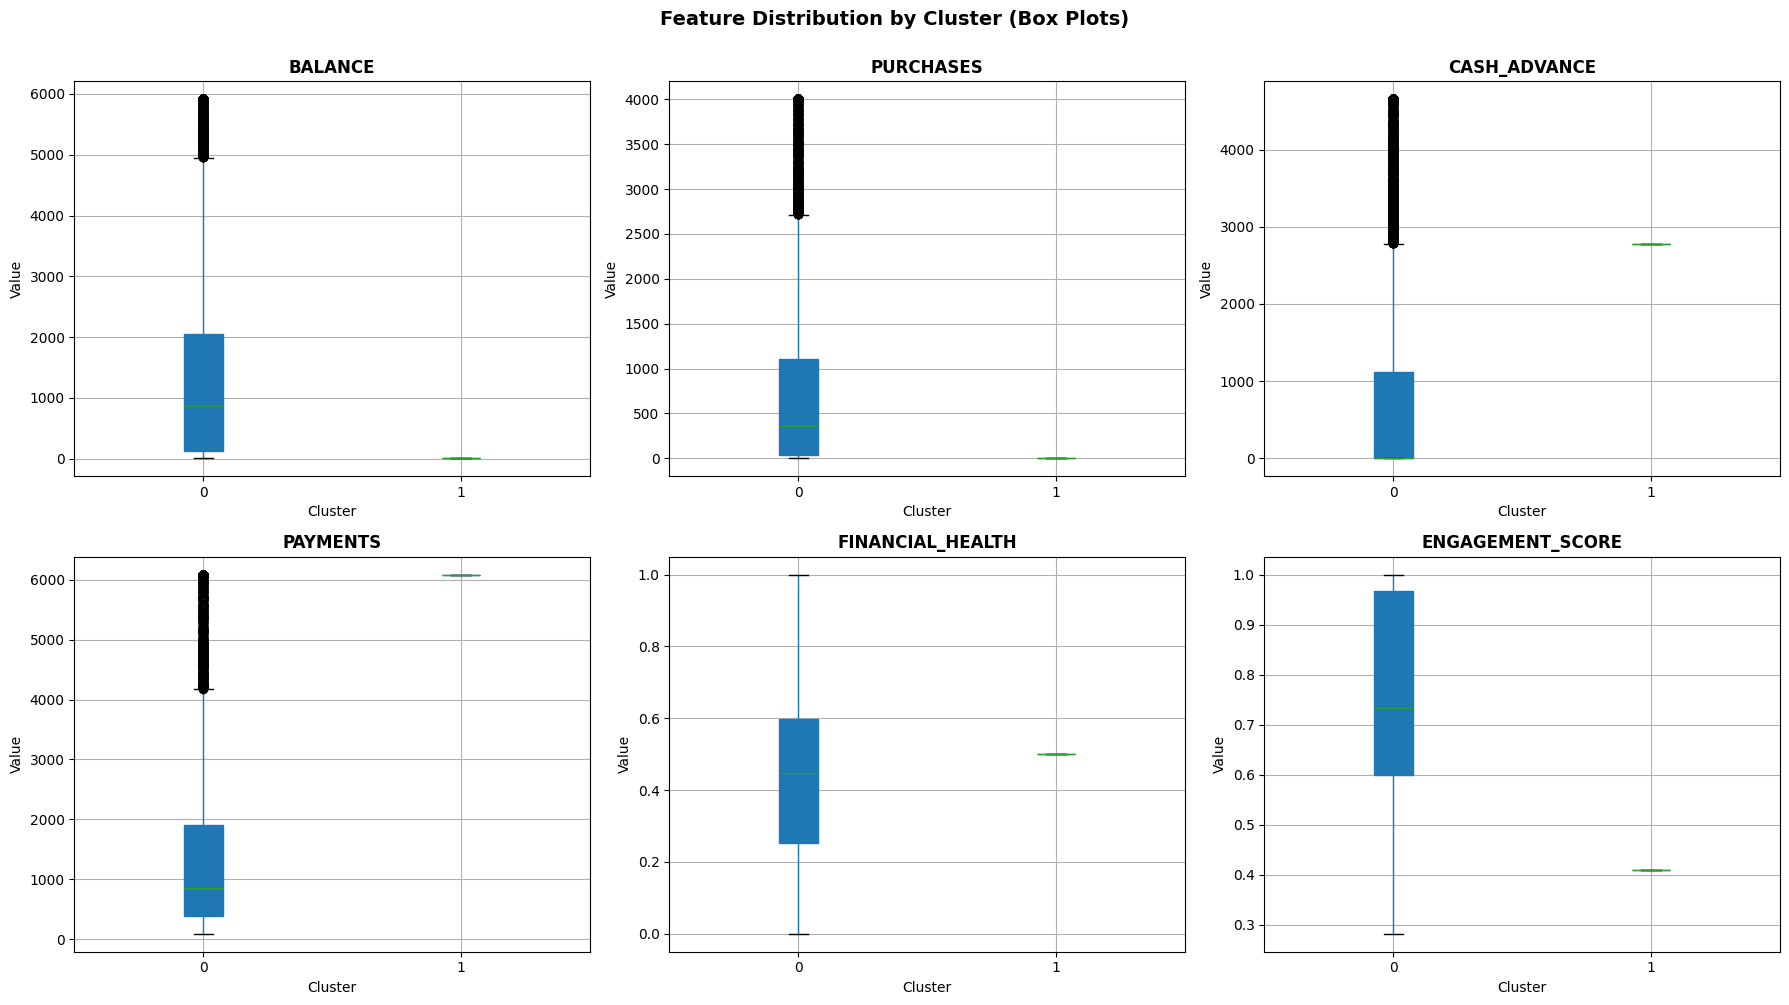

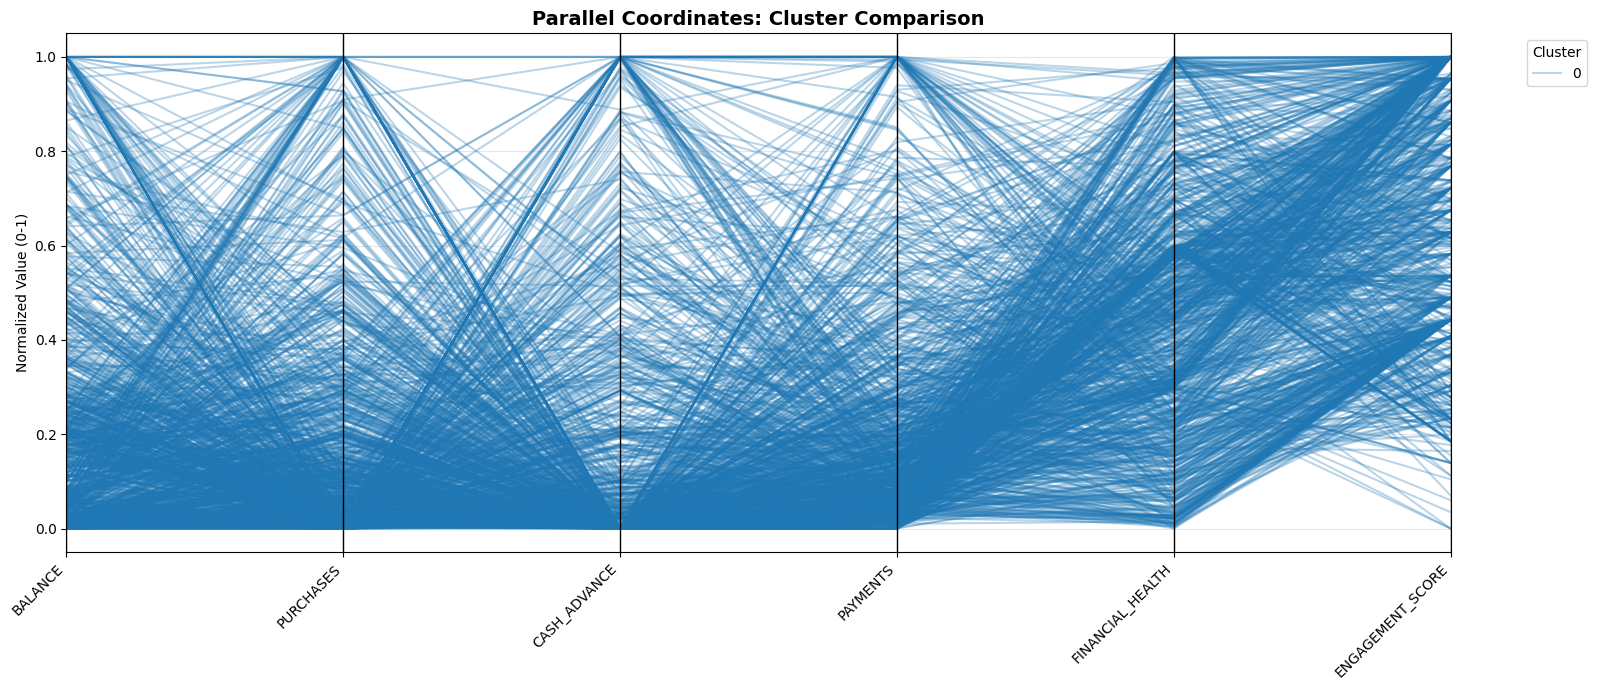

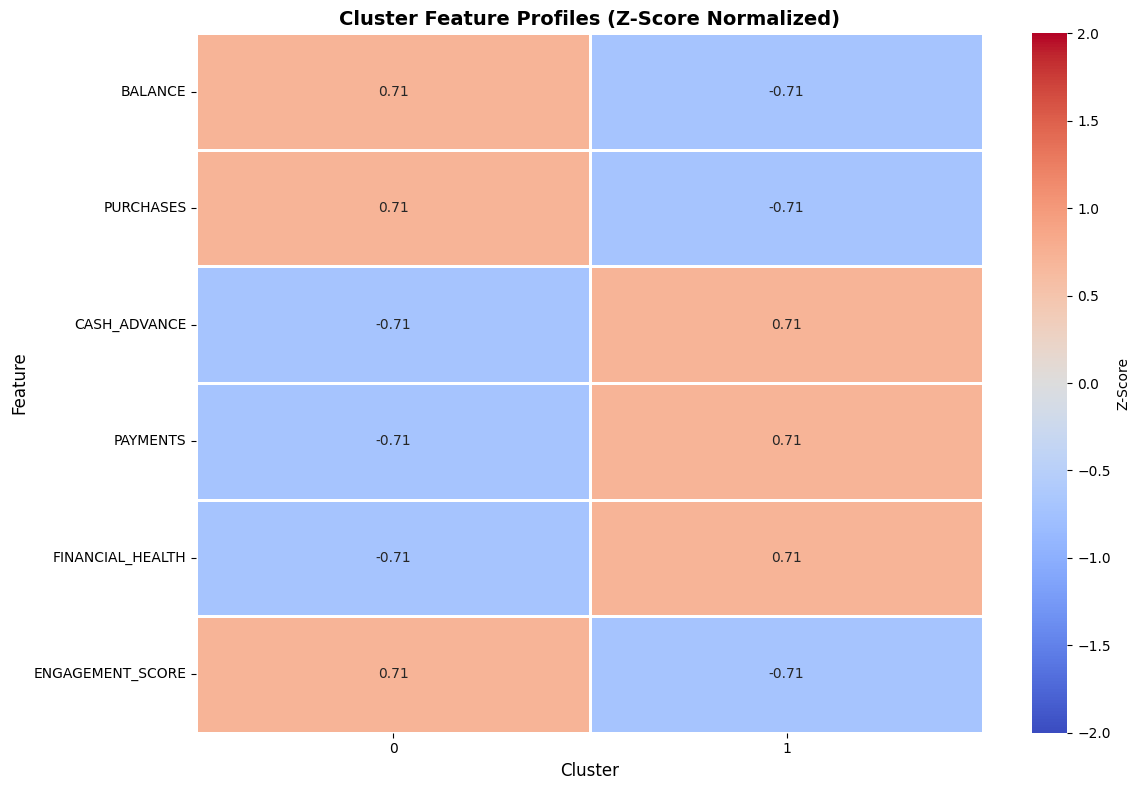

✅ Created: Box plots, Parallel coordinates, and Z-score heatmap


In [9]:
# Alternative: Box plots + Parallel coordinates + Enhanced heatmap
from pandas.plotting import parallel_coordinates

# Prepare data
viz_features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'PAYMENTS',
                'FINANCIAL_HEALTH', 'ENGAGEMENT_SCORE']
viz_features = [f for f in viz_features if f in df_clustered.columns]

# 1. Box Plots for Distribution Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, feature in enumerate(viz_features):
    df_clustered.boxplot(column=feature, by='Cluster', ax=axes[i], patch_artist=True)
    axes[i].set_title(f'{feature}', fontweight='bold')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Value')
    plt.sca(axes[i])
    plt.xticks(rotation=0)

plt.suptitle('Feature Distribution by Cluster (Box Plots)',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('cluster_boxplots.png', dpi=300)
plt.show()

# 2. Parallel Coordinates Plot
sample_for_parallel = df_clustered.sample(n=min(1000, len(df_clustered)), random_state=42)
parallel_data = sample_for_parallel[viz_features + ['Cluster']].copy()

# Normalize for parallel coordinates
for col in viz_features:
    parallel_data[col] = (parallel_data[col] - parallel_data[col].min()) / \
                         (parallel_data[col].max() - parallel_data[col].min() + 1e-8)

plt.figure(figsize=(16, 7))
parallel_coordinates(parallel_data, 'Cluster', colormap='tab10', alpha=0.3)
plt.title('Parallel Coordinates: Cluster Comparison', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Normalized Value (0-1)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('parallel_coordinates.png', dpi=300)
plt.show()

# 3. Enhanced Heatmap with Annotations
cluster_means = df_clustered.groupby('Cluster')[viz_features].mean()

# Normalize by z-score for better comparison
cluster_zscore = (cluster_means - cluster_means.mean()) / (cluster_means.std() + 1e-8)

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_zscore.T, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, linewidths=1, cbar_kws={'label': 'Z-Score'},
            vmin=-2, vmax=2)
plt.title('Cluster Feature Profiles (Z-Score Normalized)',
          fontweight='bold', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('cluster_heatmap_zscore.png', dpi=300)
plt.show()

print("✅ Created: Box plots, Parallel coordinates, and Z-score heatmap")

# STEP 9: Cluster Interpretation

Langkah terakhir sekaligus yang paling penting adalah memberikan nama segmen bisnis dan rekomendasi strategis untuk setiap cluster. Proses ini dimulai dengan pembuatan fungsi advanced_cluster_interpretation, yang menggunakan logika berbasis aturan (rule-based logic) serta nilai kuantil global (persentil 25 dan 75) untuk mengkategorikan setiap cluster berdasarkan beberapa dimensi perilaku penting, seperti Spending Behavior (tinggi, moderat, rendah), Payment Behavior (Transactor atau Revolver), Cash Advance Usage (heavy atau minimal), Credit Utilization (tinggi atau sehat), dan Engagement Level (tinggi atau rendah). Melalui kombinasi aturan-aturan tersebut, setiap cluster kemudian dipetakan ke dalam Segmentasi Bisnis yang relevan, misalnya “💎 VIP Transactor”, “💳 Profitable Revolver”, atau “😴 Dormant User”, lengkap dengan penetapan Business Value (seperti High Value atau High Risk) serta tingkat risiko yang sesuai.

In [10]:
# Alternative: Rule-based interpretation with business context
def advanced_cluster_interpretation(profiles, data_full):
    """
    Enhanced interpretation using multiple dimensions:
    - Spending level (PURCHASES)
    - Credit behavior (BALANCE, CREDIT_LIMIT)
    - Payment discipline (PRC_FULL_PAYMENT, PAYMENTS)
    - Cash advance usage (CASH_ADVANCE)
    - Engagement (transaction frequency)
    """

    interpretations = {}

    # Calculate global thresholds
    thresholds = {
        'purchases_high': data_full['PURCHASES'].quantile(0.75),
        'purchases_low': data_full['PURCHASES'].quantile(0.25),
        'balance_high': data_full['BALANCE'].quantile(0.75),
        'cash_advance_high': data_full['CASH_ADVANCE'].quantile(0.75),
        'full_payment_high': data_full['PRC_FULL_PAYMENT'].quantile(0.75),
        'trx_high': data_full['PURCHASES_TRX'].quantile(0.75),
        'credit_util_high': 0.7,
        'engagement_high': data_full['ENGAGEMENT_SCORE'].quantile(0.75) if 'ENGAGEMENT_SCORE' in data_full.columns else 0.7
    }

    for cluster in profiles.index:
        profile = profiles.loc[cluster]
        traits = []
        segment_name = "Standard User"
        risk_level = "Low"

        # Extract key metrics
        purchases = profile['PURCHASES']
        balance = profile['BALANCE']
        cash_adv = profile['CASH_ADVANCE']
        full_pay_pct = profile['PRC_FULL_PAYMENT']
        trx_freq = profile['PURCHASES_TRX']
        credit_limit = profile['CREDIT_LIMIT']
        payments = profile['PAYMENTS']

        # Calculate derived metrics
        credit_util = balance / (credit_limit + 1e-8)
        cash_ratio = cash_adv / (purchases + cash_adv + 1e-8)

        # ===============================================
        # DIMENSION 1: SPENDING BEHAVIOR
        # ===============================================
        if purchases >= thresholds['purchases_high']:
            spending_cat = "High"
            traits.append(f"💰 High spender: ${purchases:,.0f} average purchases (Top 25%)")
        elif purchases <= thresholds['purchases_low']:
            spending_cat = "Low"
            traits.append(f"💰 Low spender: ${purchases:,.0f} average purchases (Bottom 25%)")
        else:
            spending_cat = "Moderate"
            traits.append(f"💰 Moderate spender: ${purchases:,.0f} average purchases")

        # ===============================================
        # DIMENSION 2: PAYMENT BEHAVIOR
        # ===============================================
        if full_pay_pct >= 0.7:
            payment_type = "Transactor"
            traits.append(f"✅ Excellent payment behavior: {full_pay_pct*100:.0f}% full payments")
        elif full_pay_pct >= 0.3:
            payment_type = "Partial"
            traits.append(f"⚖️ Mixed payment behavior: {full_pay_pct*100:.0f}% full payments")
        else:
            payment_type = "Revolver"
            traits.append(f"🔄 Revolving balance: Only {full_pay_pct*100:.0f}% full payments")

        # ===============================================
        # DIMENSION 3: CASH ADVANCE USAGE
        # ===============================================
        if cash_adv >= thresholds['cash_advance_high']:
            traits.append(f"💵 Heavy cash advance user: ${cash_adv:,.0f} (Top 25%)")
            traits.append(f"   └─ Cash ratio: {cash_ratio*100:.1f}% of total credit usage")
            risk_level = "High"
        elif cash_adv > 500:
            traits.append(f"💵 Moderate cash advance: ${cash_adv:,.0f}")
        else:
            traits.append(f"💵 Minimal cash advance: ${cash_adv:,.0f}")

        # ===============================================
        # DIMENSION 4: CREDIT UTILIZATION
        # ===============================================
        if credit_util >= thresholds['credit_util_high']:
            traits.append(f"⚠️ High credit utilization: {credit_util*100:.1f}% of ${credit_limit:,.0f} limit")
            if risk_level == "Low":
                risk_level = "Medium"
        elif credit_util <= 0.3:
            traits.append(f"✅ Healthy credit usage: {credit_util*100:.1f}% of ${credit_limit:,.0f} limit")
        else:
            traits.append(f"📊 Moderate credit usage: {credit_util*100:.1f}% of ${credit_limit:,.0f} limit")

        # ===============================================
        # DIMENSION 5: ENGAGEMENT LEVEL
        # ===============================================
        if trx_freq >= thresholds['trx_high']:
            engagement = "High"
            traits.append(f"📈 Highly active: {trx_freq:.0f} transactions (Top 25%)")
        elif trx_freq <= 5:
            engagement = "Low"
            traits.append(f"📉 Low activity: {trx_freq:.0f} transactions")
        else:
            engagement = "Moderate"
            traits.append(f"📊 Moderate activity: {trx_freq:.0f} transactions")

        # ===============================================
        # DIMENSION 6: FINANCIAL HEALTH SCORE
        # ===============================================
        if 'FINANCIAL_HEALTH' in profile.index:
            fin_health = profile['FINANCIAL_HEALTH']
            if fin_health >= 0.7:
                traits.append(f"🏆 Excellent financial health: {fin_health:.2f}/1.00")
            elif fin_health >= 0.5:
                traits.append(f"👍 Good financial health: {fin_health:.2f}/1.00")
            else:
                traits.append(f"⚠️ Fair financial health: {fin_health:.2f}/1.00")

        # ===============================================
        # SEGMENTATION LOGIC (Business Naming)
        # ===============================================

        # Segment 1: Premium/VIP customers
        if spending_cat == "High" and payment_type == "Transactor" and engagement == "High":
            segment_name = "💎 VIP Transactor"
            business_value = "Highest Value"
            recommendation = "Retain with premium rewards, exclusive benefits, credit limit increase offers"

        # Segment 2: High-value revolvers (profitable)
        elif spending_cat == "High" and payment_type == "Revolver" and credit_util >= 0.5:
            segment_name = "💳 Profitable Revolver"
            business_value = "High Revenue"
            recommendation = "Monitor credit risk, offer balance transfer, payment plan assistance"

        # Segment 3: Cash advance dependent (high risk)
        elif cash_adv >= thresholds['cash_advance_high'] and cash_ratio > 0.4:
            segment_name = "💵 Cash Advance Seeker"
            business_value = "High Risk"
            recommendation = "Risk management needed, alternative product offerings, financial counseling"

        # Segment 4: Inactive/dormant
        elif spending_cat == "Low" and engagement == "Low" and trx_freq <= 3:
            segment_name = "😴 Dormant User"
            business_value = "Low Engagement"
            recommendation = "Reactivation campaigns, special promotions, usage incentives"

        # Segment 5: Growing customers
        elif spending_cat == "Moderate" and payment_type == "Transactor" and engagement == "Moderate":
            segment_name = "🌱 Growing Customer"
            business_value = "Medium Potential"
            recommendation = "Nurture with targeted offers, spending category bonuses, upgrade paths"

        # Segment 6: Careful spenders
        elif spending_cat == "Low" and payment_type == "Transactor" and credit_util < 0.3:
            segment_name = "🎯 Conservative User"
            business_value = "Low Risk"
            recommendation = "Educational content, category-specific rewards, small spending incentives"

        # Segment 7: At-risk customers
        elif credit_util >= 0.7 and full_pay_pct < 0.3:
            segment_name = "⚠️ At-Risk Customer"
            business_value = "High Risk"
            recommendation = "Credit counseling, payment plans, risk mitigation strategies"

        # Segment 8: Balanced users
        elif spending_cat == "Moderate" and payment_type == "Partial":
            segment_name = "⚖️ Balanced User"
            business_value = "Medium Value"
            recommendation = "Standard engagement, seasonal promotions, maintain relationship"

        # Default
        else:
            segment_name = "📊 Standard Customer"
            business_value = "Medium Value"
            recommendation = "Regular engagement, monitor behavior changes"

        # Store interpretation
        interpretations[cluster] = {
            'name': segment_name,
            'traits': traits,
            'business_value': business_value,
            'risk_level': risk_level,
            'recommendation': recommendation
        }

    return interpretations

# ===============================================
# RUN INTERPRETATION
# ===============================================
print("\n" + "="*80)
print("🎯 ADVANCED CLUSTER INTERPRETATION WITH BUSINESS INSIGHTS")
print("="*80)

cluster_profiles = df_clustered.groupby('Cluster')[profile_features].mean()
interpretations = advanced_cluster_interpretation(cluster_profiles, df_clustered)

# ===============================================
# DISPLAY RESULTS
# ===============================================
for cluster in sorted(interpretations.keys()):
    info = interpretations[cluster]
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
    n_customers = len(cluster_data)
    pct = n_customers / len(df_clustered) * 100

    print(f"\n{'='*80}")
    print(f"  CLUSTER {cluster}: {info['name']}")
    print(f"{'='*80}")
    print(f"  📊 Size: {n_customers:,} customers ({pct:.1f}% of portfolio)")
    print(f"  💼 Business Value: {info['business_value']}")
    print(f"  🎲 Risk Level: {info['risk_level']}")

    print(f"\n  🔍 KEY CHARACTERISTICS:")
    for trait in info['traits']:
        print(f"     • {trait}")

    print(f"\n  💡 BUSINESS RECOMMENDATION:")
    print(f"     → {info['recommendation']}")

    # Statistical summary
    print(f"\n  📈 CLUSTER STATISTICS:")
    print(f"     ├─ Avg Purchases: ${cluster_data['PURCHASES'].mean():,.0f} (Median: ${cluster_data['PURCHASES'].median():,.0f})")
    print(f"     ├─ Avg Balance: ${cluster_data['BALANCE'].mean():,.0f}")
    print(f"     ├─ Avg Payments: ${cluster_data['PAYMENTS'].mean():,.0f}")
    print(f"     ├─ Avg Cash Advance: ${cluster_data['CASH_ADVANCE'].mean():,.0f}")
    print(f"     ├─ Avg Credit Limit: ${cluster_data['CREDIT_LIMIT'].mean():,.0f}")
    print(f"     └─ Full Payment Rate: {cluster_data['PRC_FULL_PAYMENT'].mean()*100:.1f}%")

# ===============================================
# BUSINESS SUMMARY TABLE
# ===============================================
print("\n" + "="*80)
print("📋 EXECUTIVE SUMMARY: CLUSTER PORTFOLIO")
print("="*80)

summary_data = []
for cluster in sorted(interpretations.keys()):
    info = interpretations[cluster]
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster]

    summary_data.append({
        'Cluster': cluster,
        'Segment': info['name'],
        'Size': len(cluster_data),
        'Pct': f"{len(cluster_data)/len(df_clustered)*100:.1f}%",
        'Value': info['business_value'],
        'Risk': info['risk_level'],
        'Avg_Spend': f"${cluster_data['PURCHASES'].mean():,.0f}",
        'Revenue_Potential': 'High' if cluster_data['BALANCE'].mean() > df_clustered['BALANCE'].quantile(0.75) else 'Medium'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save interpretation
with open('cluster_interpretations.txt', 'w') as f:
    f.write("CLUSTER INTERPRETATION REPORT\n")
    f.write("="*80 + "\n\n")
    for cluster, info in interpretations.items():
        f.write(f"CLUSTER {cluster}: {info['name']}\n")
        f.write(f"Business Value: {info['business_value']}\n")
        f.write(f"Risk Level: {info['risk_level']}\n")
        f.write(f"Recommendation: {info['recommendation']}\n")
        f.write("\nTraits:\n")
        for trait in info['traits']:
            f.write(f"  - {trait}\n")
        f.write("\n" + "-"*80 + "\n\n")

print("\n✅ Saved detailed interpretation to 'cluster_interpretations.txt'")


🎯 ADVANCED CLUSTER INTERPRETATION WITH BUSINESS INSIGHTS

  CLUSTER 0: 📊 Standard Customer
  📊 Size: 8,949 customers (100.0% of portfolio)
  💼 Business Value: Medium Value
  🎲 Risk Level: Low

  🔍 KEY CHARACTERISTICS:
     • 💰 Moderate spender: $824 average purchases
     • 🔄 Revolving balance: Only 15% full payments
     • 💵 Moderate cash advance: $817
     • 📊 Moderate credit usage: 33.3% of $4,366 limit
     • 📊 Moderate activity: 13 transactions
     • ⚠️ Fair financial health: 0.45/1.00

  💡 BUSINESS RECOMMENDATION:
     → Regular engagement, monitor behavior changes

  📈 CLUSTER STATISTICS:
     ├─ Avg Purchases: $824 (Median: $361)
     ├─ Avg Balance: $1,453
     ├─ Avg Payments: $1,479
     ├─ Avg Cash Advance: $817
     ├─ Avg Credit Limit: $4,366
     └─ Full Payment Rate: 15.4%

  CLUSTER 1: 💵 Cash Advance Seeker
  📊 Size: 1 customers (0.0% of portfolio)
  💼 Business Value: High Risk
  🎲 Risk Level: High

  🔍 KEY CHARACTERISTICS:
     • 💰 Low spender: $0 average purchases 

Hasil interpretasi ini disajikan dalam bentuk profil lengkap setiap cluster yang mencakup nama segmen, ukuran cluster, nilai bisnis, tingkat risiko, serta daftar key characteristics berdasarkan statistik rata-rata. Selain itu, diberikan pula Business Recommendation yang spesifik dan dapat ditindaklanjuti, misalnya program retensi untuk segmen berharga, kampanye reaktivasi untuk segmen pasif, atau langkah mitigasi risiko untuk segmen berisiko tinggi. Sebagai pelengkap, dibuat Executive Summary berupa tabel ringkas yang memudahkan presentasi kepada manajemen. Seluruh hasil interpretasi kemudian disimpan secara rapi dalam file teks cluster_interpretations.txt sebagai dokumentasi akhir.